In [1]:
# Step 1: Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.cm as cm

In [2]:
# Load 2000 dataset
dataset_path = 'years/2000.csv'
df = pd.read_csv(dataset_path)

In [3]:
# 2010 dataset
d2010 = pd.read_csv('years/2010.csv')

In [4]:
# Take only G06 class
g06 = df[df['Class'] == 'G06']
# Drop columns that are not needed (keep only Text and Subclass (it is the label))
g06 = g06[['Text', 'Subclass']]
# Display the number of patents per subclass
g06["Subclass"].value_counts()

Subclass
G06F    78594
G06Q     4749
G06K     3261
G06T     2081
G06G      701
G06N      349
G06E       64
G06J       21
G06M       18
G06C       15
G06H        8
G06D        4
G06R        3
G06P        2
G06B        1
G06S        1
Name: count, dtype: int64

In [5]:
# Remove rows with less than 2 subclasses (we need at least 2 subclasses to train and test)
g06 = g06[g06['Subclass'].map(g06['Subclass'].value_counts()) >= 2]
g06["Subclass"].value_counts()

Subclass
G06F    78594
G06Q     4749
G06K     3261
G06T     2081
G06G      701
G06N      349
G06E       64
G06J       21
G06M       18
G06C       15
G06H        8
G06D        4
G06R        3
G06P        2
Name: count, dtype: int64

In [6]:
# Оставим только 3 подкласса для упрощения задачи
g06 = df[df['Subclass'].isin(['G05B', 'H01L'])]
g06["Subclass"].value_counts()

Subclass
H01L    1573
G05B    1366
Name: count, dtype: int64

In [7]:
g06_2012 = d2010[d2010['Subclass'].isin(['G05B', 'H01L'])]
g06_2012["Subclass"].value_counts()

Subclass
H01L    1389
G05B     977
Name: count, dtype: int64

In [8]:
# Split the dataset into training and testing sets
train_df, test_df = train_test_split(g06, test_size=0.2, random_state=42, shuffle=True, stratify=g06['Subclass'])

train_df = g06
test_df = g06_2012

In [9]:
# Model
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1, 1),
        lowercase=True,
        stop_words='english',
    )),
    ('clf', LogisticRegression(
        solver='newton-cg',
        multi_class='ovr',
        n_jobs=-1,
        class_weight='balanced'
    ))
])
pipeline.fit(train_df['Text'], train_df['Subclass'])
predictions = pipeline.predict(test_df['Text'])
print(classification_report(test_df['Subclass'], predictions))

              precision    recall  f1-score   support

        G05B       0.86      0.96      0.91       977
        H01L       0.97      0.89      0.93      1389

    accuracy                           0.92      2366
   macro avg       0.92      0.93      0.92      2366
weighted avg       0.93      0.92      0.92      2366



In [10]:
cr = classification_report(test_df['Subclass'], predictions, output_dict=True)

In [11]:
# t-SNE
from sklearn.manifold import TSNE
# we can also use PCA
from sklearn.decomposition import PCA
# we can also use UMAP
from umap import UMAP
# or LDA

pca = PCA(n_components=2, random_state=412)
tsne = TSNE(n_components=2, random_state=42)
# umap = UMAP(n_components=2, random_state=42)
umap = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='cosine')

# plt_result_train = pca.fit_transform(pipeline.named_steps['tfidf'].transform(train_df['Text']).toarray())
# plt_result_test = pca.transform(pipeline.named_steps['tfidf'].transform(test_df['Text']).toarray())

# plt_result_train = tsne.fit_transform(pipeline.named_steps['tfidf'].transform(train_df['Text']).toarray())
# plt_result_test = tsne.fit_transform(pipeline.named_steps['tfidf'].transform(test_df['Text']).toarray())

plt_result_train = umap.fit_transform(pipeline.named_steps['tfidf'].transform(train_df['Text']).toarray())
plt_result_test = umap.transform(pipeline.named_steps['tfidf'].transform(test_df['Text']).toarray())

In [22]:
disp_limit = 1000
# Get a subset of samples for each class
subset_train_indices = []
subset_test_indices = []

for class_label in train_df['Subclass'].unique():
    class_indices_train = np.where(train_df['Subclass'] == class_label)[0][:disp_limit]
    class_indices_test = np.where(test_df['Subclass'] == class_label)[0][:disp_limit]
    
    subset_train_indices.extend(class_indices_train)
    subset_test_indices.extend(class_indices_test)

In [23]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['Subclass'])
test_labels_encoded = label_encoder.transform(test_df['Subclass'])
for class_label in train_df['Subclass'].unique():
    class_indices_train = np.where(train_df['Subclass'] == class_label)[0][:disp_limit]
    subset_train_indices.extend(class_indices_train)
    class_indices_test = np.where(test_df['Subclass'] == class_label)[0][:disp_limit]
    subset_test_indices.extend(class_indices_test)

In [24]:
classes = train_df['Subclass'].unique()
colors = cm.rainbow(np.linspace(0, 1, len(classes)))

C:\Users\SilkSlime\AppData\Local\Temp\ipykernel_5540\1707390333.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(plt_result_train[subset_train_indices, 0][indices], plt_result_train[subset_train_indices, 1][indices], c=color, label=label)


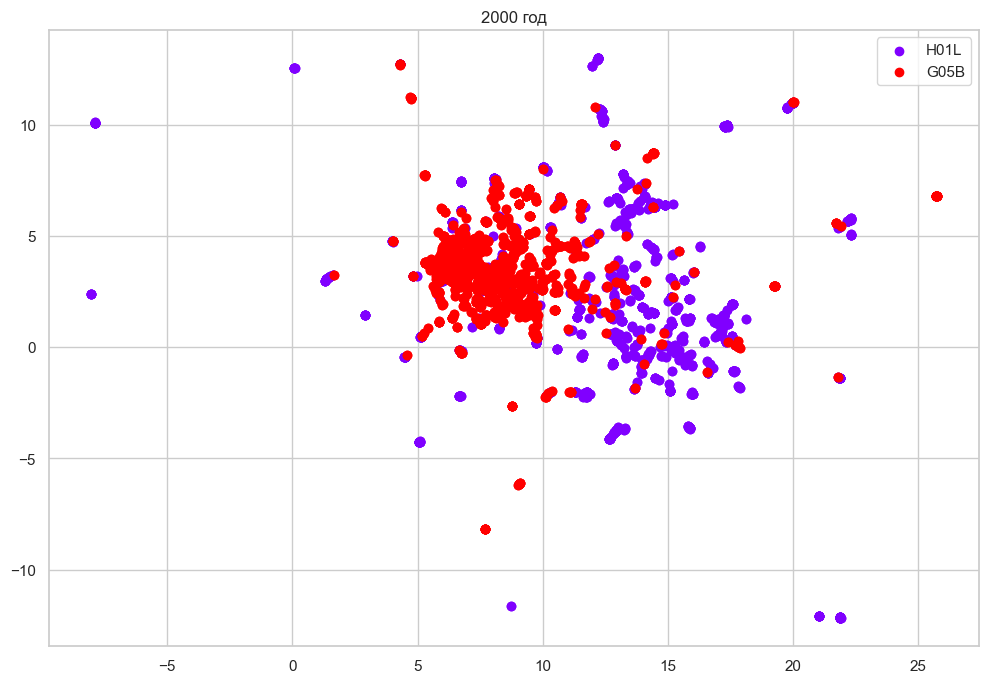

In [25]:
labels = label_encoder.inverse_transform(train_labels_encoded[subset_train_indices])
plt.figure(figsize=(12, 8))
for label, color in zip(classes, colors):
    indices = np.where(labels == label)
    plt.scatter(plt_result_train[subset_train_indices, 0][indices], plt_result_train[subset_train_indices, 1][indices], c=color, label=label)
plt.title('2000 год')
plt.legend()

C:\Users\SilkSlime\AppData\Local\Temp\ipykernel_5540\246155506.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(plt_result_test[subset_test_indices, 0][indices], plt_result_test[subset_test_indices, 1][indices], c=color, label=label)


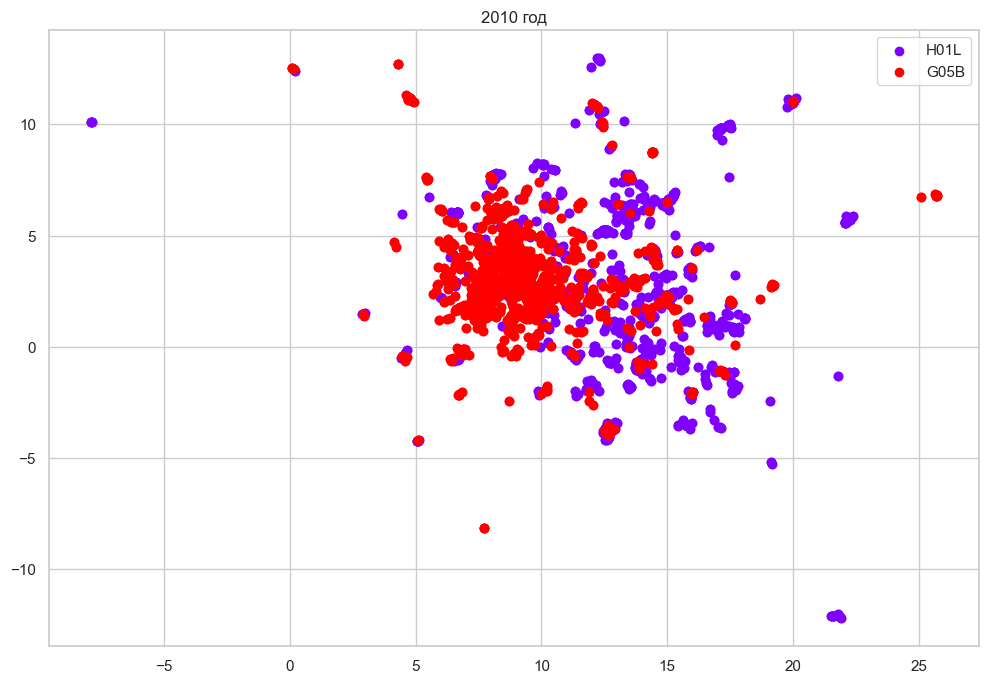

In [26]:
labels = label_encoder.inverse_transform(test_labels_encoded[subset_test_indices])
plt.figure(figsize=(12, 8))
for label, color in zip(classes, colors):
    indices = np.where(labels == label)
    plt.scatter(plt_result_test[subset_test_indices, 0][indices], plt_result_test[subset_test_indices, 1][indices], c=color, label=label)
plt.title('2010 год')
plt.legend()

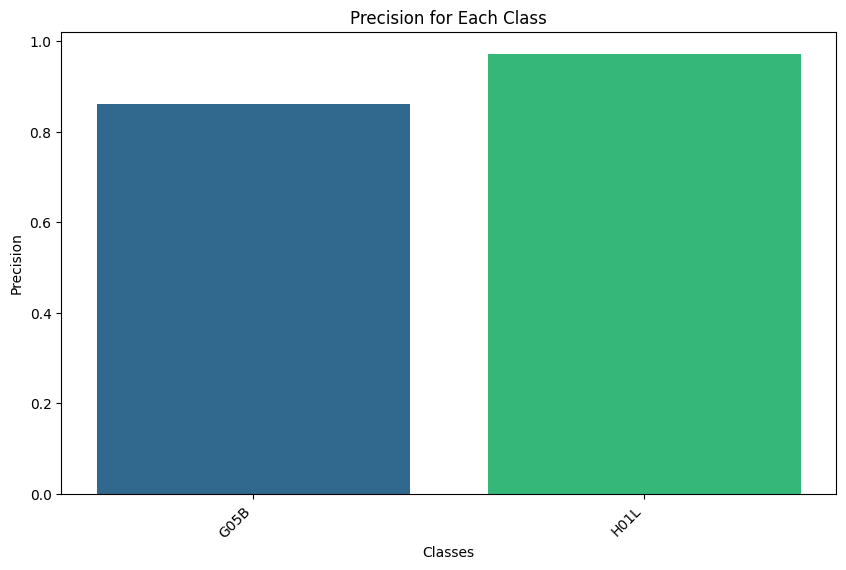

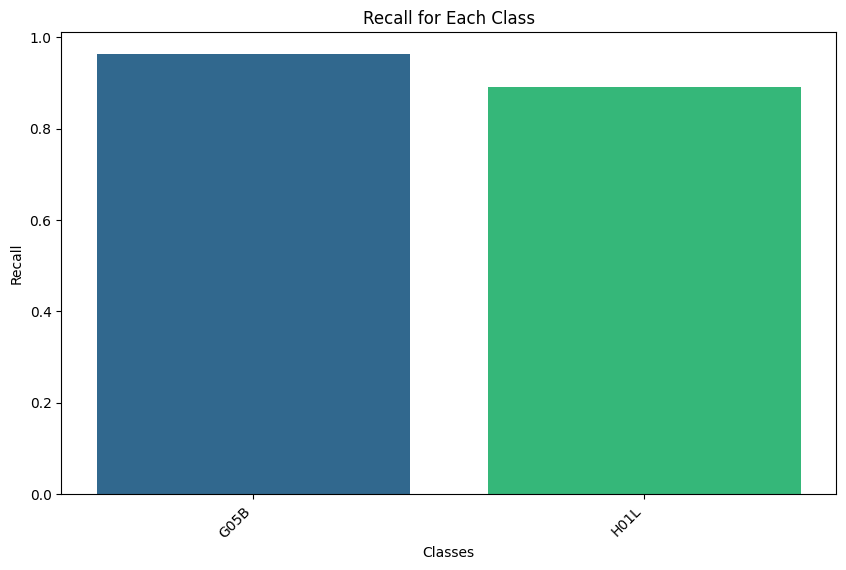

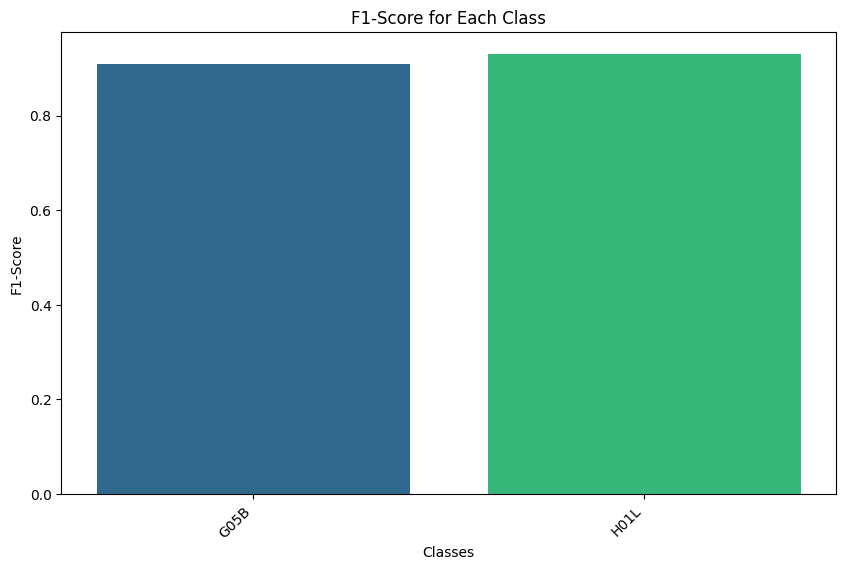

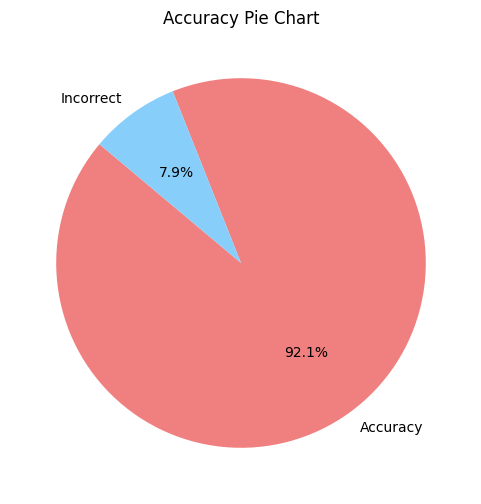

In [17]:
# Extract class names and corresponding metrics
classes = list(cr.keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'
precision = [cr[class_]['precision'] for class_ in classes]
recall = [cr[class_]['recall'] for class_ in classes]
f1_score = [cr[class_]['f1-score'] for class_ in classes]

# Plotting the bar charts
plt.figure(figsize=(10, 6))

# Precision
plt.bar(classes, precision, color=sns.color_palette("viridis", len(classes)))
plt.title('Precision for Each Class')
plt.xlabel('Classes')
plt.ylabel('Precision')
plt.xticks(rotation=45, ha='right')
plt.show()

# Recall
plt.figure(figsize=(10, 6))
plt.bar(classes, recall, color=sns.color_palette("viridis", len(classes)))
plt.title('Recall for Each Class')
plt.xlabel('Classes')
plt.ylabel('Recall')
plt.xticks(rotation=45, ha='right')
plt.show()

# F1-Score
plt.figure(figsize=(10, 6))
plt.bar(classes, f1_score, color=sns.color_palette("viridis", len(classes)))
plt.title('F1-Score for Each Class')
plt.xlabel('Classes')
plt.ylabel('F1-Score')
plt.xticks(rotation=45, ha='right')
plt.show()

# Accuracy Pie Chart
accuracy = cr['accuracy'] * 100
labels = ['Accuracy', 'Incorrect']
sizes = [accuracy, 100 - accuracy]
colors = ['lightcoral', 'lightskyblue']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Accuracy Pie Chart')
plt.show()

In [18]:
pred_train = pipeline.predict(train_df['Text'])
cr_train = classification_report(train_df['Subclass'], pred_train, output_dict=True)

In [19]:
cr = classification_report(test_df['Subclass'], predictions, output_dict=True)

In [20]:
cl = list(cr.keys())[:-3]
p_train = [cr_train[class_]['precision'] for class_ in cl]
p_test = [cr[class_]['precision'] for class_ in classes]
r1 = {c:p for c,p in zip(cl, p_train)}
r2 = {c:p for c,p in zip(cl, p_test)}
differences = {key: r2[key] - r1[key] for key in r1}


C:\Users\SilkSlime\AppData\Local\Temp\ipykernel_5540\3137148246.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df.index, y='Precision', data=df, palette='viridis')


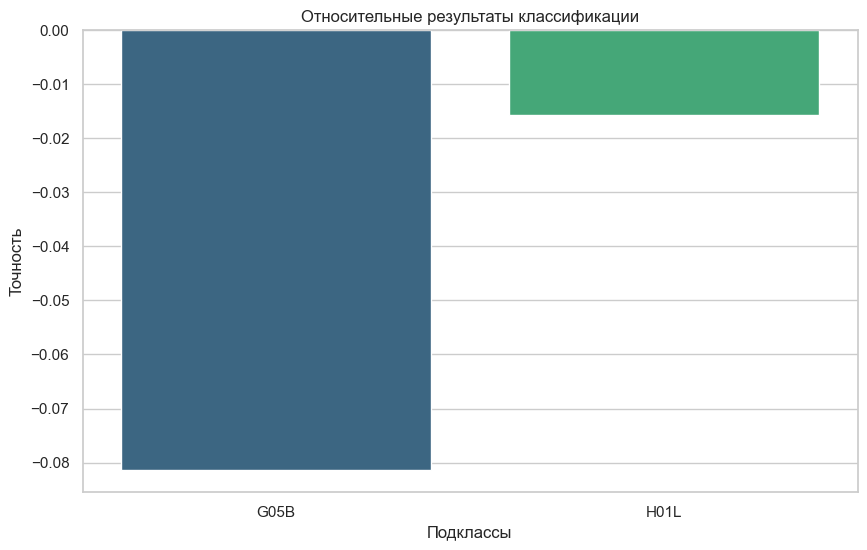

In [21]:
# Creating a DataFrame
df = pd.DataFrame.from_dict(differences, orient='index', columns=['Precision'])

# Setting a more scientific style with Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plotting the bar chart
sns.barplot(x=df.index, y='Precision', data=df, palette='viridis')

# Adding labels and title
plt.xlabel('Подклассы')
plt.ylabel('Точность')
plt.title('Относительные результаты классификации')

# Displaying the plot
plt.show()